# TF-IDF Random Forest

In [1]:
FILE_NAME = 'tf_idf_random_forest'
GRAPH_TITLE = 'TF-IDF + Random Forest'

In [2]:
import polars as pl
from utils.load_data import get_data

In [3]:
X_train, X_test, y_train, y_test = get_data("s")

## Fit Model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [5]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(use_idf=True)),
        ("clf", RandomForestClassifier(n_jobs=-2, n_estimators=100))
    ]
)

In [6]:
classifier = pipeline.fit(X_train, y_train)

In [7]:
classifier.classes_

array(['false', 'true'], dtype=object)

## Evaluation

In [8]:
from utils.plot import plot_eval
import sklearn.metrics as metrics

In [9]:
y_pred = classifier.predict(X_test)
clf_report = metrics.classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

       false       0.94      0.94      0.94     15956
        true       0.94      0.94      0.94     16044

    accuracy                           0.94     32000
   macro avg       0.94      0.94      0.94     32000
weighted avg       0.94      0.94      0.94     32000



In [10]:
evaluation_reuslt = {
    "auc": metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]),
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "precision": metrics.precision_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "recall": metrics.recall_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "f1": metrics.f1_score(y_test, y_pred, pos_label='true'), # type: ignore
}
evaluation_reuslt

{'auc': 0.9861653113907924,
 'accuracy': 0.94046875,
 'precision': 0.93983699371617,
 'recall': 0.9415357766143106,
 'f1': 0.9406856182084256}

/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


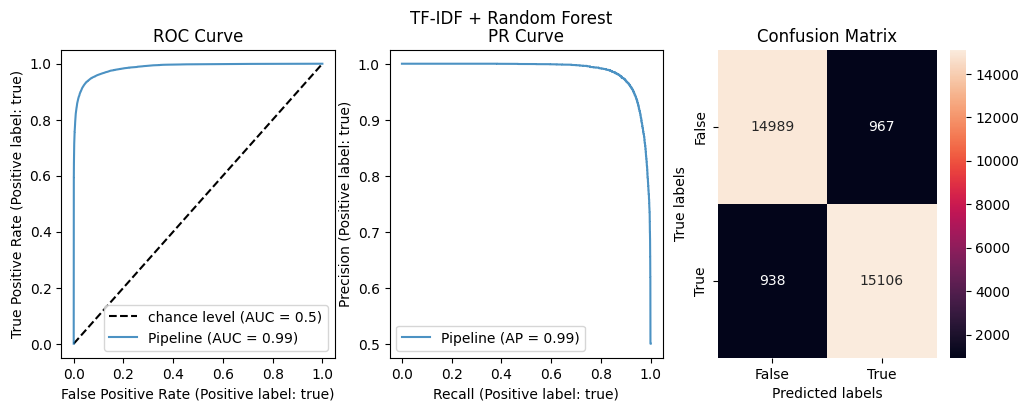

In [11]:
plt = plot_eval(X_test, y_test, y_pred, classifier, GRAPH_TITLE)
plt.savefig(f"output/{FILE_NAME}.png")

## LIAR Test

In [12]:
from utils.load_data import load_liar

X_liar, y_liar = load_liar()

In [13]:
from sklearn.metrics import classification_report

y_liar_pred = classifier.predict(X_liar)

clf_report_liar = classification_report(y_liar, y_liar_pred)
print(clf_report_liar)

              precision    recall  f1-score   support

       false       0.65      0.28      0.39      8284
        true       0.35      0.73      0.48      4507

    accuracy                           0.44     12791
   macro avg       0.50      0.50      0.43     12791
weighted avg       0.55      0.44      0.42     12791



/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


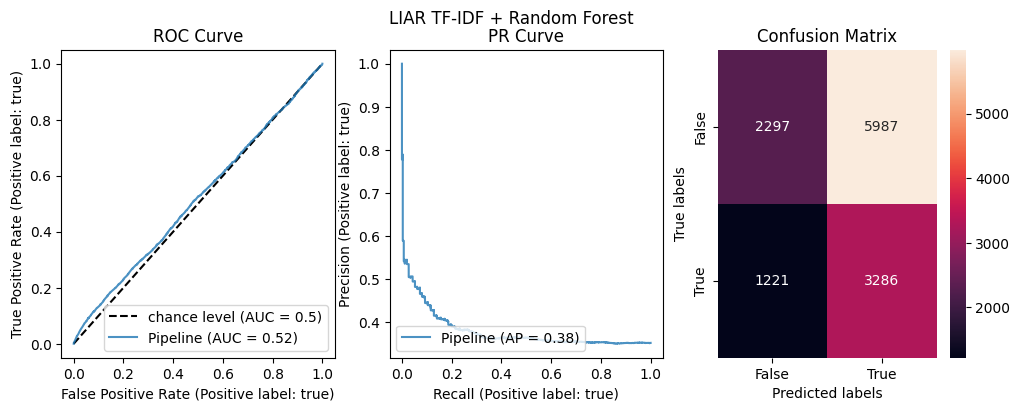

In [14]:
plt = plot_eval(X_liar, y_liar, y_liar_pred, classifier, f"LIAR {GRAPH_TITLE}")
plt.savefig(f"output/{FILE_NAME}_liar.png")

In [15]:
import json 

with open(f'./output/result_eval_{FILE_NAME}.txt', 'w') as writer:
    writer.write("Evaluation Result\n")
    writer.write(clf_report)
    writer.write('\n')
    writer.write("LIAR Evaluation Result\n")
    writer.write(clf_report_liar)
    writer.write('\n')
    writer.write("Accurate Result\n")
    writer.write(json.dumps(evaluation_reuslt, indent=4))

## Export model

In [16]:
from joblib import dump, load
dump(classifier, f'output/{FILE_NAME}.joblib') 

['output/tf_idf_random_forest.joblib']

In [17]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

initial_type = [("text", StringTensorType([None,]))]
onx = convert_sklearn(classifier, initial_types=initial_type)
with open(f"output/{FILE_NAME}.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [18]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy

sess = rt.InferenceSession(f"output/{FILE_NAME}.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [19]:
pred_onx = sess.run(None, {input_name: X_test})
pred_onx

[array(['false', 'false', 'false', ..., 'true', 'false', 'false'],
       dtype=object),
 [{'false': 0.8799999952316284, 'true': 0.11999998241662979},
  {'false': 0.699999988079071, 'true': 0.30000001192092896},
  {'false': 1.0, 'true': 0.0},
  {'false': -1.1920928955078125e-07, 'true': 1.0000001192092896},
  {'false': 0.2300000786781311, 'true': 0.7699999213218689},
  {'false': 0.09999996423721313, 'true': 0.9000000357627869},
  {'false': -1.1920928955078125e-07, 'true': 1.0000001192092896},
  {'false': 0.10000002384185791, 'true': 0.8999999761581421},
  {'false': 0.5800000429153442, 'true': 0.41999995708465576},
  {'false': 0.36000001430511475, 'true': 0.6399999856948853},
  {'false': 0.8600000143051147, 'true': 0.14000000059604645},
  {'false': 0.9246953129768372, 'true': 0.07530470192432404},
  {'false': 0.9900000095367432, 'true': 0.009999999776482582},
  {'false': 0.6509999632835388, 'true': 0.3490000367164612},
  {'false': 1.0, 'true': 0.0},
  {'false': 0.7300000190734863, 'true